In [1023]:
import faiss as fs
import numpy as np
import fastText as ft
from numpy import genfromtxt
import pandas as pd
import re
import csv
import itertools
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report,f1_score
from sklearn import svm
from scipy import sparse
from sklearn import preprocessing
from collections import defaultdict, Counter
from sklearn.datasets import dump_svmlight_file
import codecs
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import re
color = sns.color_palette()

%matplotlib inline

In [1046]:
ft_model_file ='/temp0/dev/anjani/data/fasttext/training_set_tec_trs04919_trs04969_ft_noclean_ml_13.bin'
subcat_file = '/temp0/dev/anjani/data/fasttext/test_set_tec_trs04919_trs04969_ft_noclean_ucase.dat'
subcat_file1 = '/temp0/dev/anjani/data/fasttext/test_set_tec_trs04919_trs04969_ft_noclean_ucase.dat1'

subcat_train_file = '/temp0/dev/anjani/data/fasttext/training_set_tec_trs04919_trs04969_ft_noclean_ucase.dat'
subcat_train_file1 = '/temp0/dev/anjani/data/fasttext/training_set_tec_trs04919_trs04969_ft_noclean_ucase.dat1'

In [987]:
nrows = 70000
df_tec = pd.read_csv(subcat_file, sep="__LABEL__",names=['desc', 'subcat'],encoding ='utf8',  nrows=nrows)

/opt/python/dev/Anaconda2-5.0.1/lib/python2.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [1031]:
inf = codecs.open(subcat_file, 'wb',encoding='utf-8')

In [1049]:
inf = codecs.open(subcat_train_file1, 'wb',encoding='utf-8')
with codecs.open(subcat_train_file, 'rb',encoding='utf-8') as f:
    for line in f.readlines():
        l = line.split("__LABEL__")
        try: inf.writelines(cleanup(l[0]) + ' ' + "__LABEL__"+l[1])
        except: print line
        
inf.close()   

WIRELESS WIRELESS BLUETOOTH åäº ä¸æ ç§æ æ å
WIRELESS WIRELESS BLUETOOTH åäº ä¸æ ç§æ æ å
WIRELESS WIRELESS BLUETOOTH åäº ä¸æ ç§æ æ å
WIRELESS WIRELESS BLUETOOTH åäº ä¸æ ç§æ æ å
WIRELESS WIRELESS ACCESSORIES åäº ä¸æ ç§æ æ å
WIRELESS WIRELESS BLUETOOTH åäº ä¸æ ç§æ æ å
WIRELESS WIRELESS BLUETOOTH åäº ä¸æ ç§æ æ å
WIRELESS WIRELESS BLUETOOTH åäº ä¸æ ç§æ æ å
OFFICE PRODUCTS LANDLINE TELEPHONE ACCESSORIES åäº ä¸æ ç§æ æ å
PC INPUTS åäº ä¸æ ç§æ æ   å
WIRELESS WIRELESS BLUETOOTH åäº ä¸æ ç§æ æ å
WIRELESS WIRELESS BLUETOOTH åäº ä¸æ ç§æ æ å
WIRELESS WIRELESS BLUETOOTH åäº ä¸æ ç§æ æ å
WIRELESS WIRELESS BLUETOOTH åäº ä¸æ ç§æ æ å
WIRELESS WIRELESS BLUETOOTH åäº ä¸æ ç§æ æ å
WIRELESS WIRELESS BLUETOOTH åäº ä¸æ ç§æ æ å
WIRELESS WIRELESS BLUETOOTH åäº ä¸æ ç§æ æ å
ELECTRONICS HEADPHONES åäº ä¸æ ç§æ æ å
WIRELESS WIRELESS ACCESSORIES åäº ä¸æ ç§æ

In [1002]:
model = ft.load_model(ft_model_file)

fasttext_pybind.args

In [1003]:
input_dim = model.get_dimension()
input_tensor = np.zeros((nrows,input_dim))


get_output_matrix = model.get_output_matrix()
labels = np.array([int(p.split("__")[2]) for p in model.get_labels()]) 

true_labels = df_tec.subcat.values

In [1044]:
def cleanup(x):
    try: x = x.replace("’","'")
    except: pass
    try: x = x.replace("′","'")
    except: pass
    x = x.replace("''"," ")
    x = x.replace("'"," ' ")
    #x = x.replace("“",'"')
    #x = x.replace("”",'"')
    x = x.replace('"',' " ')
    x = x.replace('\.',' \. ')
    x = x.replace('<br \','>')
    x = x.replace(',',' , ')
    x = x.replace('(',' ( ')
    x = x.replace(')',' ) ')
    x = x.replace('!',' ! ')
    x = x.replace('?',' ? ')
    x = x.replace(';',' ; ')
    x = x.replace(':',' : ')
    x = x.replace('-',' - ')
    x = x.replace('=',' = ')
    x = x.replace('*',' * ')
    #x = x.replace('+',' + ')
    x = x.replace('|',' ')
    #x = x.replace('«',' ')
    #x = x.replace('&',' & ')
    return re.sub('[0-9]',' ',x)
    

In [1028]:
cleanup('CTO S SYSTEMS APPLE COMPUTO-AUDIO MBP13/I5/2.3GHZ/8GB/512GB/INGLES+')

'CTO S SYSTEMS APPLE COMPUTO - AUDIO MBP  /I / . GHZ/ GB/   GB/INGLES+'

In [1004]:


model_pred=[]
i=0
with codecs.open('/temp0/dev/anjani/data/fasttext/test_set_tec_trs04919_trs04969_ft_noclean_ucase.dat','rb',encoding='utf-8') as f:
    for line in f.readlines():
        if i < nrows:
            inp = line.split("__LABEL__")[0]
            input_tensor[i] = model.get_sentence_vector(inp)
            model_pred.append(model.predict(inp)[0][0])
            i=i+1
        
model_pred = np.array([int(p.split("__")[2]) for p in model_pred])

In [1005]:
print input_tensor.shape
print get_output_matrix.shape

(70000, 100)
(532, 100)


In [1006]:
model_pred.shape

(70000,)

In [924]:

def uncertain_predict_output(input_tensor, no_of_pred, threshold=2, dropout = 0.9):
    result_dict={}
    no_of_feature = input_tensor.shape[1]
    no_of_sample = input_tensor.shape[0]
    no_of_labels = get_output_matrix.shape[0]
    
   
    
    l = [list(labels[np.argmax(np.dot(input_tensor,get_output_matrix.T*\
    np.random.binomial(1, dropout, no_of_labels*no_of_feature).reshape((no_of_feature,no_of_labels)).astype(int)),axis =1)])\
        for i in range(no_of_pred)]    
    l= np.array([list(Counter(np.argmax(i,axis=1)).most_common(1)[0])+ [cnt] + [true_labels[cnt]] for cnt,i in enumerate(np.array(l).T)])
    
    
    new_tensor_gt_threshold = l[np.where(l[:,1]>threshold)]
    if len(new_tensor_gt_threshold)==0:
        print "Threshold %d doesn't yield any prediction" %threshold
        return 0,0
    result_dict['coverage'] = float(new_tensor_gt_threshold.shape[0])/float(no_of_sample)
    result_dict['accuracy_no_threshold'] = float((np.where(l[:,0]==l[:,3]))[0].shape[0])/float(no_of_sample)
    result_dict['accuracy_after_threshold'] = float((np.where(new_tensor_gt_threshold[:,0]==new_tensor_gt_threshold[:,3]))[0].shape[0])\
    /float(new_tensor_gt_threshold.shape[0])
    result_dict['accuracy'] = float((np.where(model_pred==l[:,3]))[0].shape[0])/float(no_of_sample)
    
    return l,result_dict


def uncertain_predict_input(input_tensor, no_of_pred, threshold=2, dropout = 0.9):
    result_dict={}
    no_of_feature = input_tensor.shape[1]
    no_of_sample = input_tensor.shape[0]
    no_of_labels = get_output_matrix.shape[0]
    
    l = [list(labels[np.argmax(np.dot(input_tensor* np.random.binomial(1, dropout, no_of_sample*no_of_feature).reshape((no_of_sample,no_of_feature)).astype(int),get_output_matrix.T),axis =1)]) for i in range(no_of_pred)]
    #print np.array(l).shape
    
    l= np.array([list(Counter(i).most_common(1)[0])+ [cnt] + [true_labels[cnt]] for cnt,i in enumerate(np.array(l).T)])
    #print np.array(l).shape
    
    new_tensor_gt_threshold = l[np.where(l[:,1]>threshold)]
    if len(new_tensor_gt_threshold)==0:
        print "Threshold %d doesn't yield any prediction" %threshold
        return 0,0
    result_dict['coverage'] = float(new_tensor_gt_threshold.shape[0])/float(no_of_sample)
    result_dict['accuracy_no_threshold'] = float((np.where(l[:,0]==l[:,3]))[0].shape[0])/float(no_of_sample)
    result_dict['accuracy_after_threshold'] = float((np.where(new_tensor_gt_threshold[:,0]==new_tensor_gt_threshold[:,3]))[0].shape[0])\
    /float(new_tensor_gt_threshold.shape[0])
    result_dict['accuracy'] = float((np.where(model_pred==l[:,3]))[0].shape[0])/float(no_of_sample)
    
    return result_dict

def uncertain_predict_Inter(input_tensor, no_of_pred, conf_threshold=2, dropout = 0.9):
    result_dict={}
    no_of_feature = input_tensor.shape[1]
    no_of_sample = input_tensor.shape[0]
    no_of_labels = get_output_matrix.shape[0]
    l = [np.dot(input_tensor,get_output_matrix.T*\
    np.random.binomial(1, dropout, no_of_labels*no_of_feature).reshape((no_of_feature,no_of_labels)).astype(int))\
         for i in range(no_of_pred)]   
    pred_determin = np.argmax(np.dot(input_tensor,get_output_matrix.T),axis=1)
    l = list(np.transpose(np.array(l),(1,0,2)))
    ll= np.array([list(Counter(np.argmax(i,axis=1)).most_common(1)[0])+ [cnt] + [true_labels[cnt]] \
                  + [np.max((np.exp(i)/np.sum(np.exp(i),axis=1)[:,None])[:,pred_determin[cnt]])] \
                 + [np.mean((np.exp(i)/np.sum(np.exp(i),axis=1)[:,None])[:,pred_determin[cnt]])] \
                  + [np.std((np.exp(i)/np.sum(np.exp(i),axis=1)[:,None])[:,pred_determin[cnt]])] \
                                   + [labels[most_common_pred[cnt]]]  for cnt,i in enumerate(l)])
    
       
    return l,ll

def uncertain_predict_conf_threshold(input_tensor, no_of_pred, conf_threshold=2, dropout = 0.9):
    result_dict={}
    no_of_feature = input_tensor.shape[1]
    no_of_sample = input_tensor.shape[0]
    no_of_labels = get_output_matrix.shape[0]
    #l = [np.dot(input_tensor,get_output_matrix.T*\
    #np.random.binomial(1, dropout, no_of_labels*no_of_feature).reshape((no_of_feature,no_of_labels)).astype(int))\
    #     for i in range(no_of_pred)]   
    
    #l = [np.dot(input_tensor*\
    #np.random.binomial(1, dropout, no_of_sample*no_of_feature).\
    #            reshape((no_of_sample,no_of_feature)).astype(int),get_output_matrix.T)\
    #     for i in range(no_of_pred)]   
    
    l = [np.dot(input_tensor *\
    np.random.binomial(1, dropout, no_of_sample*no_of_feature).reshape((no_of_sample,no_of_feature)).astype(int),
        get_output_matrix.T*\
    np.random.binomial(1, dropout, no_of_labels*no_of_feature).reshape((no_of_feature,no_of_labels)).astype(int))\
         for i in range(no_of_pred)]   
    
    pred_determin = np.argmax(np.dot(input_tensor,get_output_matrix.T),axis=1)
    l = list(np.transpose(np.array(l),(1,0,2)))
    l= np.array([[cnt] + [true_labels[cnt]] \
                  + [np.max((np.exp(i)/np.sum(np.exp(i),axis=1)[:,None])[:,pred_determin[cnt]])] \
                 + [np.mean((np.exp(i)/np.sum(np.exp(i),axis=1)[:,None])[:,pred_determin[cnt]])] \
                  + [np.std((np.exp(i)/np.sum(np.exp(i),axis=1)[:,None])[:,pred_determin[cnt]])] \
                                   + [labels[pred_determin[cnt]]]  for cnt,i in enumerate(l)])
    
    new_tensor_gt_threshold = l[np.where(l[:,3]>conf_threshold)]
    if len(new_tensor_gt_threshold)==0:
        print "Conf Threshold %f doesn't yield any prediction" %conf_threshold
        return 
    result_dict['coverage'] = float(new_tensor_gt_threshold.shape[0])/float(no_of_sample)
    result_dict['accuracy_no_threshold'] = float((np.where(l[:,1]==l[:,5]))[0].shape[0])/float(no_of_sample)
    result_dict['accuracy_after_threshold'] = float((np.where(new_tensor_gt_threshold[:,1]==new_tensor_gt_threshold[:,5]))[0].shape[0])\
    /float(new_tensor_gt_threshold.shape[0])
    #result_dict['accuracy'] = float((np.where(pred_determin==l[:,1]))[0].shape[0])/float(no_of_sample)
       
    return result_dict

def uncertain_predict_full(input_tensor, no_of_pred, dropout = 0.9):
    result_dict={}
    no_of_feature = input_tensor.shape[1]
    no_of_sample = input_tensor.shape[0]
    no_of_labels = get_output_matrix.shape[0]
    l = [np.dot(input_tensor *\
    np.random.binomial(1, dropout, no_of_sample*no_of_feature).reshape((no_of_sample,no_of_feature)).astype(int),
        get_output_matrix.T*\
    np.random.binomial(1, dropout, no_of_labels*no_of_feature).reshape((no_of_feature,no_of_labels)).astype(int))\
         for i in range(no_of_pred)]   
    
    pred_determin = np.argmax(np.dot(input_tensor,get_output_matrix.T),axis=1)
    l = list(np.transpose(np.array(l),(1,0,2)))
    l= np.array([[cnt] + [true_labels[cnt]] \
                  + [np.max((np.exp(i)/np.sum(np.exp(i),axis=1)[:,None])[:,pred_determin[cnt]])] \
                 + [np.mean((np.exp(i)/np.sum(np.exp(i),axis=1)[:,None])[:,pred_determin[cnt]])] \
                  + [np.std((np.exp(i)/np.sum(np.exp(i),axis=1)[:,None])[:,pred_determin[cnt]])] \
                                   + [labels[pred_determin[cnt]]]  for cnt,i in enumerate(l)])
    return l



In [919]:
#print uncertain_predict_input(input_tensor=input_tensor,no_of_pred =100,threshold=80, dropout = 0.9)

print uncertain_predict_conf_threshold(input_tensor=input_tensor[:10000],no_of_pred =100,conf_threshold=0.98, dropout = 0.95)
print uncertain_predict_conf_threshold(input_tensor=input_tensor[:10000],no_of_pred =100,conf_threshold=0.98, dropout = 0.90)
print uncertain_predict_conf_threshold(input_tensor=input_tensor[:10000],no_of_pred =100,conf_threshold=0.98, dropout = 0.85)
print uncertain_predict_conf_threshold(input_tensor=input_tensor[:10000],no_of_pred =100,conf_threshold=0.98, dropout = 0.80)


{'accuracy_after_threshold': 0.9679974651457541, 'accuracy_no_threshold': 0.8616, 'coverage': 0.6312}
{'accuracy_after_threshold': 0.977878985035784, 'accuracy_no_threshold': 0.8616, 'coverage': 0.4611}
{'accuracy_after_threshold': 0.9849624060150376, 'accuracy_no_threshold': 0.8616, 'coverage': 0.3192}
{'accuracy_after_threshold': 0.9927606177606177, 'accuracy_no_threshold': 0.8616, 'coverage': 0.2072}


In [920]:
print uncertain_predict_conf_threshold(input_tensor=input_tensor[:10000],no_of_pred =100,conf_threshold=0.97, dropout = 0.95)
print uncertain_predict_conf_threshold(input_tensor=input_tensor[:10000],no_of_pred =100,conf_threshold=0.95, dropout = 0.95)
print uncertain_predict_conf_threshold(input_tensor=input_tensor[:10000],no_of_pred =100,conf_threshold=0.93, dropout = 0.95)
print uncertain_predict_conf_threshold(input_tensor=input_tensor[:10000],no_of_pred =100,conf_threshold=0.90, dropout = 0.95)

{'accuracy_after_threshold': 0.9654808561953573, 'accuracy_no_threshold': 0.8616, 'coverage': 0.6634}
{'accuracy_after_threshold': 0.9611914649863955, 'accuracy_no_threshold': 0.8616, 'coverage': 0.6983}
{'accuracy_after_threshold': 0.9588607594936709, 'accuracy_no_threshold': 0.8616, 'coverage': 0.7268}
{'accuracy_after_threshold': 0.9531662269129287, 'accuracy_no_threshold': 0.8616, 'coverage': 0.758}


In [1255]:
l = uncertain_predict_full(input_tensor=input_tensor[:70000],no_of_pred =100,dropout = 0.95)

In [1256]:
print classification_report(true_labels[most_var[:1000]],model_pred[most_var[:1000]], digits=6)

             precision    recall  f1-score   support

      11233   0.000000  0.000000  0.000000         0
      36944   0.000000  0.000000  0.000000         1
      36947   0.000000  0.000000  0.000000         1
      36948   0.000000  0.000000  0.000000         0
      36949   0.000000  0.000000  0.000000         8
      36951   1.000000  0.500000  0.666667         2
      36952   0.000000  0.000000  0.000000         1
      36957   0.000000  0.000000  0.000000         2
      36959   0.000000  0.000000  0.000000         0
      36963   0.000000  0.000000  0.000000         5
      36964   0.000000  0.000000  0.000000         1
      36969   0.500000  0.222222  0.307692         9
      36974   0.000000  0.000000  0.000000         2
      36975   0.000000  0.000000  0.000000         3
      36976   0.000000  0.000000  0.000000         1
      36979   0.500000  1.000000  0.666667         1
      36982   0.000000  0.000000  0.000000         3
      36983   0.000000  0.000000  0.000000   

In [1272]:
uncertainty_new = l[:,3]

In [1253]:
#df_tec.iloc[most_var[69700:]]
#df_tec.iloc[most_var[69900:]]
#df_tec['mean_conf'] = l[:,3]
#df_tec['pred'] = model_pred
#df_tec['desc1'] = df_tec['desc'].apply(lambda x: x.replace(",",""))
df_tec.to_csv('/temp0/dev/anjani/data/fasttext/test_set_tec_trs04919_trs04969_pred_with_mean_conf.csv',sep="|",index=False,header=False, columns=['desc1','subcat','pred','mean_conf'] )

In [1161]:
df_tec.iloc[54842].desc

'OFFICE SUPPLIES AND STAMPS DOT COM - DSV ESSENDANT POSTIT25X30QUADPAD2*CT CT '

In [1276]:
total_rec_cnt = uncertainty_new.shape[0]
most_var = np.argsort(uncertainty_new)
fc=[f1_score(true_labels[most_var[i:]],model_pred[most_var[i:]], average='weighted') for i in range(0,total_rec_cnt,1000)]  #
mean_var=[np.mean(uncertainty_new[i:]) for i in range(0,total_rec_cnt,1000)]

In [1280]:
#mean_var

In [1277]:
fc_size = zip([round(float(i)/float(total_rec_cnt)*100,2) for i  in range(total_rec_cnt,0,-1000)],fc)

pd_fc_size = pd.DataFrame({"Pct_Rec":[float(i)/float(total_rec_cnt) for i  in range(total_rec_cnt,0,-1000)],"Score":fc})

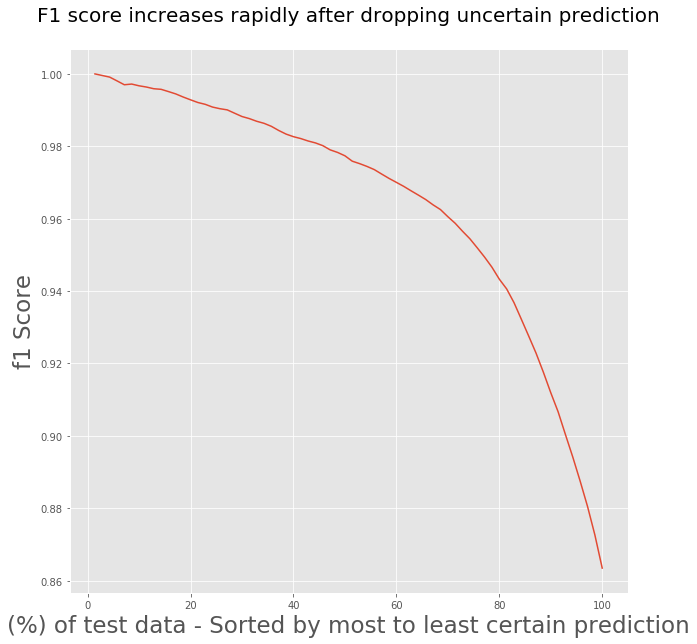

In [1278]:
plt.figure(figsize=(10,10))
plt.xlabel("(%) of test data - Sorted by most to least certain prediction", size=23)
plt.ylabel("f1 Score", size=23)
plt.title("F1 score increases rapidly after dropping uncertain prediction\n", size=20)
plt.grid(True)
plt.plot([round(float(i)/float(total_rec_cnt)*100,2) for i  in range(total_rec_cnt,0,-1000)], fc)
#plt.plot([round(float(i)/float(total_rec_cnt)*100,2) for i  in range(total_rec_cnt,0,-1000)],[0.97 for i  in range(total_rec_cnt,0,-1000)])


In [1267]:
fc_bin=[f1_score(true_labels[most_var[i:i+1000]],model_pred[most_var[i:i+1000]], average='weighted') for i in range(0,total_rec_cnt,1000)]  #
mean_var_bin=[np.mean(uncertainty_new[i:i+1000]) for i in range(0,total_rec_cnt,1000)]

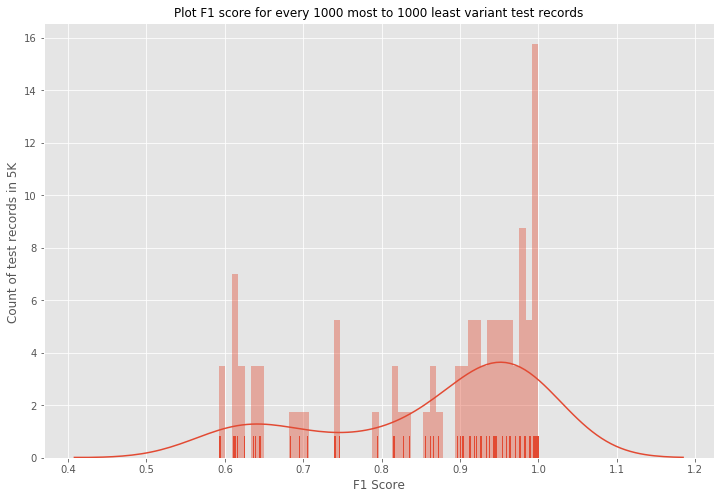

In [1268]:
plt.figure(figsize=(12,8))
sns.distplot(fc_bin,kde=True,bins=50,rug=True)
plt.xlabel("F1 Score",fontsize=12)
plt.grid(True)
plt.ylabel("Count of test records in 5K ",fontsize=12)
plt.title('Plot F1 score for every 1000 most to 1000 least variant test records', fontsize=12)
plt.show()
plt.gcf().clear()
plt.clf()
plt.cla()
plt.close()

In [533]:
def uncertain_predict(no_of_pred, no_of_sample, no_of_feature=1000):
    l = [list(clf_sgd.predict(X_test[:no_of_sample]*\
                              np.random.binomial(1, 0.5, no_of_sample*no_of_feature).reshape((no_of_sample,no_of_feature)))\
              .astype(int)) for i in range(no_of_pred)]
    return [Counter(i).most_common(1)[0][0] for i in np.array(l).T]

def uncertain_predict_one(no_of_pred, sample_no, no_of_feature=1000):
    X_test1 = X_test[sample_no].reshape(1,no_of_feature)
    l = [list(clf_sgd.predict(X_test1*np.random.binomial(1, 0.5, no_of_feature).reshape((1,no_of_feature)))\
              .astype(int)) for i in range(no_of_pred)]
    return Counter(list(np.array(l).T[0])).most_common(1)



In [541]:
#%%time

no_of_sample = 10000
no_of_pred = 100 
res = np.array(uncertain_predict(no_of_pred=no_of_pred,no_of_sample=no_of_sample))
print f1_score( y_test[:no_of_sample],res, average='weighted')      
#print f1_score( clf_sgd.predict(X_test[:no_of_sample]),res, average='weighted')      
print f1_score( y_test[:no_of_sample],clf_sgd.predict(X_test[:no_of_sample]), average='weighted')      



0.421689056976513
0.6096390444385337


In [538]:
y_test_list = df_tec.subcat.values
def uncertain_predict_temp(no_of_pred, no_of_sample, no_of_feature=100, threshold=50, dropout = 0.5):
    result_dict={}
    l = [list(clf_sgd.predict(X_test[:no_of_sample]*\
                              np.random.binomial(1, dropout, no_of_sample*no_of_feature).reshape((no_of_sample,no_of_feature)))\
              .astype(int)) for i in range(no_of_pred)]
    l= np.array([list(Counter(i).most_common(1)[0])+ [cnt] + [y_test_list[cnt]] for cnt,i in enumerate(np.array(l).T)])
    new_tensor_gt_threshold = l[np.where(l[:,1]>threshold)]
    result_dict['coverage'] = float(new_tensor_gt_threshold.shape[0])/float(no_of_sample)
    result_dict['accuracy_no_threshold'] = float((np.where(l[:,0]==l[:,3]))[0].shape[0])/float(no_of_sample)
    result_dict['accuracy_after_threshold'] = float((np.where(new_tensor_gt_threshold[:,0]==new_tensor_gt_threshold[:,3]))[0].shape[0])\
    /float(new_tensor_gt_threshold.shape[0])
    result_dict['accuracy'] = float((np.where(clf_sgd.predict(X_test[:no_of_sample])==l[:,3]))[0].shape[0])/float(no_of_sample)
    
    return result_dict
    

In [539]:
%%time
print uncertain_predict_temp(no_of_pred=100,no_of_sample=2000,threshold=50,dropout=0.5)
print uncertain_predict_temp(no_of_pred=100,no_of_sample=2000,threshold=50,dropout=0.6)
print uncertain_predict_temp(no_of_pred=100,no_of_sample=2000,threshold=50,dropout=0.7)
print uncertain_predict_temp(no_of_pred=100,no_of_sample=2000,threshold=50,dropout=0.8)
print uncertain_predict_temp(no_of_pred=100,no_of_sample=2000,threshold=50,dropout=0.9)
print uncertain_predict_temp(no_of_pred=100,no_of_sample=2000,threshold=50,dropout=0.95)


{'accuracy_after_threshold': 0.6149732620320856, 'accuracy_no_threshold': 0.414, 'coverage': 0.4675, 'accuracy': 0.63}
{'accuracy_after_threshold': 0.694468085106383, 'accuracy_no_threshold': 0.509, 'coverage': 0.5875, 'accuracy': 0.63}
{'accuracy_after_threshold': 0.697724039829303, 'accuracy_no_threshold': 0.573, 'coverage': 0.703, 'accuracy': 0.63}
{'accuracy_after_threshold': 0.678743961352657, 'accuracy_no_threshold': 0.6045, 'coverage': 0.828, 'accuracy': 0.63}
{'accuracy_after_threshold': 0.6566200215285253, 'accuracy_no_threshold': 0.6215, 'coverage': 0.929, 'accuracy': 0.63}
{'accuracy_after_threshold': 0.6374358974358975, 'accuracy_no_threshold': 0.627, 'coverage': 0.975, 'accuracy': 0.63}
CPU times: user 15min 4s, sys: 26.9 s, total: 15min 31s
Wall time: 33.5 s


In [490]:
%%time
print uncertain_predict_temp(no_of_pred=100,no_of_sample=2000,threshold=99)

{'accuracy_after_threshold': 1.0, 'coverage': 0.0175, 'accuracy': 0.755}
CPU times: user 6min 44s, sys: 15 s, total: 6min 59s
Wall time: 33.8 s


In [476]:
new_reslt = resl[np.where(resl[:,1]>10)]
print new_reslt.shape
print (np.where(new_reslt[:,0]==new_reslt[:,3]))[0].shape
print (np.where(resl[:,1]>10))[0].shape[0]
print (np.where(resl[:,0]==resl[:,3]))[0].shape[0]

print float((np.where(resl[:,0]==resl[:,3]) and np.where(resl[:,1]>10))[0].shape[0])/float((np.where(resl[:,1]>10))[0].shape[0])

print float((np.where(resl[:,0]==resl[:,3]))[0].shape[0])/float(resl.shape[0])

#np.where((resl[:,0]==resl[:,3]))

#np.where((resl[:,1]>50))

(492, 4)
(373,)
492
373
1.0
0.746


In [353]:
y_test_list = y_test.tolist()
y_true = []
y_pred = []
for i in range(100):
    pred = uncertain_predict_one(100,i)
    if pred[0][1] > 90:
        y_pred.append(pred[0][0])
        y_true.append(y_test_list[i])

In [354]:
print f1_score(np.array(y_true),np.array(y_pred), average='weighted')

0.8333333333333334


In [1164]:
def f(x):
    """The function to predict."""
    return x * np.sin(x)

In [1166]:
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T

In [1174]:
y = f(X).ravel()

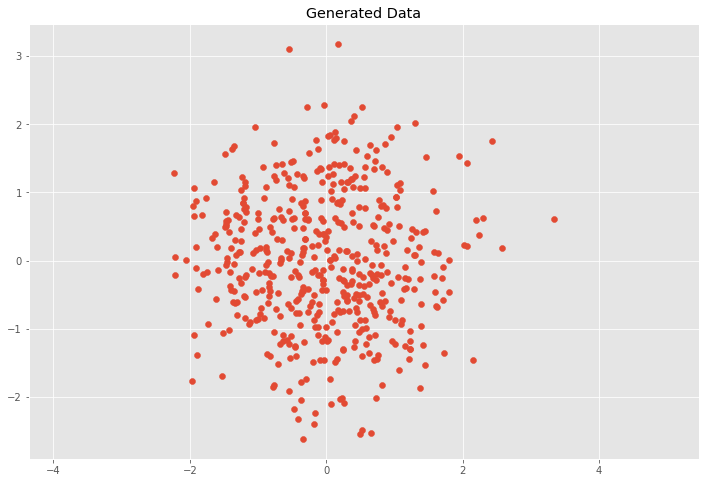

In [1254]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

# Normal distributed x and y vector with mean 0 and standard deviation 1
x = np.random.normal(0, 1, 500)
y = np.random.normal(0, 1, 500)
X = np.vstack((x, y)).T

plt.scatter(X[:, 0], X[:, 1])
plt.title('Generated Data')
plt.axis('equal');

In [1227]:
def cov(x, y):
    xbar, ybar = x.mean(), y.mean()
    
    return np.sum((x - xbar)*(y - ybar))/(len(x) - 1)

# Covariance matrix
def cov_mat(X):
    return np.array([[cov(X[0], X[0]), cov(X[0], X[1])], \
                     [cov(X[1], X[0]), cov(X[1], X[1])]])

# Calculate covariance matrix 
#covr = cov_mat(X.T) # (or with np.cov(X.T))

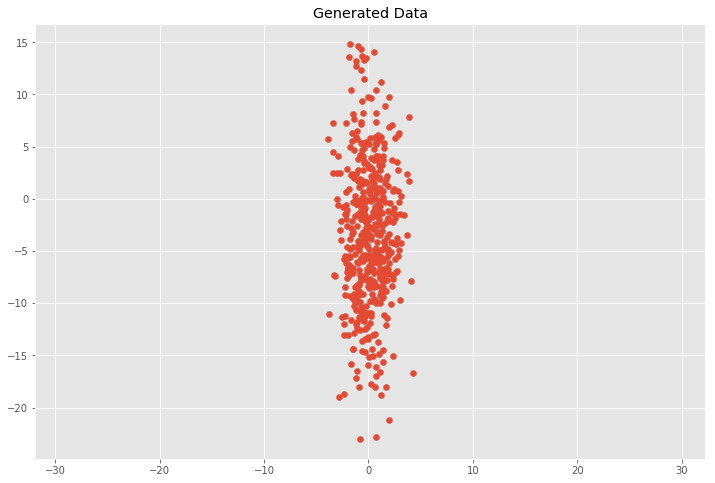

In [1228]:

covr = cov_mat(X.T)
sx, sy = 0.7, 3.4
covr = np.array([[sx, 0], [0, sy]])
Xcap = np.dot(covr, X.T).T
X= Xcap

plt.scatter(Xcap[:, 0], Xcap[:, 1])
plt.title('Generated Data')
plt.axis('equal');

In [1190]:
X.shape

(500, 2)

In [1225]:
covr

array([[ 6.11146294e+16, -8.17479943e+15],
       [-8.17479943e+15,  4.46540687e+15]])